In [1]:
import numpy as np
import pandas as pd
import os
import csv
import re
from dotenv import load_dotenv
import json
from openai import OpenAI
from sentence_transformers import SentenceTransformer
import glob
import PyPDF2 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PyPDF2 import PdfReader
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from difflib import SequenceMatcher

/home/cptaswadu/RESCUE-n8n/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/home/cptaswadu/RESCUE-n8n/insurance'
load_dotenv(dotenv_path=os.path.join(path, ".env"))
openai_api_key = os.getenv("OPEN_AI_API_KEY")
perplexity_api_key = os.getenv("PERPLEXITY_API_KEY")
chatgpt_client = OpenAI(api_key=openai_api_key)

In [3]:
answer_policy_dir = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/policy_answer"
for filename in os.listdir(answer_policy_dir):
    file_path = os.path.join(answer_policy_dir, filename)
    if os.path.isfile(file_path):
        with open(file_path, "rb") as f:
            content = f.read()
            md5_hash = hashlib.md5(content).hexdigest()
        print(f"{filename} => {md5_hash}")

Aetna_Breast and Ovarian Cancer Susceptibility Gene Testing, Prophylactic Mastectomy, and Prophylactic Oophorectomy - Medical Clinical Policy Bulletins.pdf => 853350c3473bcef32091186fbb7318fd
Aetna_Genetic Testing - Medical Clinical Policy Bulletins.pdf => af9f1086001f5b00ec242195723c10bf
United Healthcare_genetic-testing-cardiac-disease.pdf => f77e783d8f23d96b1932bc0f7cf7e8c7
Cigna_MOL.TS_.306.C_Whole_Genome_Sequencing_Cigna_eff01.01.2025_pub09.10.2024.pdf => 36bb5264dda1b2027dcdfdd32a714204
Cigna_MOL.TS_.238.A_BRCA_Analysis_eff01.01.2025_pub09.10.2024_1.pdf => 626eac4d60df057ea93ece78f8cc3dfc
United Healthcare_genetic-testing-hereditary-cancer.pdf => c69485372670ce1d12aa8f61d83a06fd
United Healthcare_genetic-testing-neuromuscular-disorders.pdf => 4dec1a815b8ecffdf00d34ad7f04836f
CapitalBC_BRCA.pdf => 34dc0823a03ca2f20ba740345d7b57da
United Healthcare_whole-exome-and-whole-genome-sequencing.pdf => 4fadf6b3ca9d4d08131cb31365e3aa7d
Cigna_MOL.TS_.235.C_Whole_Exome_Sequencing_Cigna_eff01.

In [4]:
def fuzzy_match(a, b, threshold=0.85):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() >= threshold

In [5]:
class RAGPolicyRetriever:
    def __init__(self, policy_folder_path, openai_api_key=None, perplexity_api_key=None, llm_model="chatgpt"):
        self.policy_folder_path = policy_folder_path
        self.policies = {}
        self.embeddings = {}
        self.embedder = SentenceTransformer("all-MiniLM-L6-v2")
        self.llm_model = llm_model
        self.openai_client = OpenAI(api_key=openai_api_key) if openai_api_key else None
        self.perplexity_api_key = perplexity_api_key

    def load_policies(self):
        pdf_files = glob.glob(os.path.join(self.policy_folder_path, "*.pdf"))
        for pdf_file in pdf_files:
            with open(pdf_file, "rb") as f:
                reader = PyPDF2.PdfReader(f)
                text = "".join(page.extract_text() or "" for page in reader.pages)
            self.policies[os.path.basename(pdf_file)] = text
        print(f"✅ Loaded {len(self.policies)} policies.")

    def embed_policies(self):
        for doc_name, doc_text in self.policies.items():
            self.embeddings[doc_name] = self.embedder.encode([doc_text])[0]
        print("✅ Embeddings created.")

    def extract_insurance_and_test(self, patient_info):
        prompt = f"""You are a clinical insurance assistant.

Given the patient information below, identify:
1. The insurance provider (e.g., United Healthcare, Aetna, Medicaid, etc.)
2. The type of genetic test (e.g., Whole Exome Sequencing, BRCA1/2, Panel, etc.)
3. States where the patient resides (e.g., California, New York, etc.)

Respond in JSON format with keys 'insurance', 'test', 'states'.

PATIENT INFORMATION:
{patient_info}
"""

        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]

        if self.llm_model == "chatgpt":
            response = self.openai_client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0
            )
            output = response.choices[0].message.content.strip()

        elif self.llm_model == "perplexity":
            headers = {
                "Authorization": f"Bearer {self.perplexity_api_key}",
                "Content-Type": "application/json"
            }
            data = {
                "model": "sonar-pro",
                "messages": messages,
                "temperature": 0
            }
            url = "https://api.perplexity.ai/chat/completions"
            res = requests.post(url, headers=headers, json=data)
            output = res.json()["choices"][0]["message"]["content"].strip()

        else:
            raise ValueError("Unsupported LLM model")

        try:
            output_json = json.loads(re.sub(r"```json|```", "", output).strip())
            insurance = output_json.get("insurance", None)
            test_name = output_json.get("test", None)
            return insurance, test_name
        except Exception as e:
            print(f"❗ JSON parsing error in extract_insurance_and_test: {e}")
            return None, None

    def filter_policies_by_insurance(self, insurance_name):
        filtered = {}
        for doc_name, doc_text in self.policies.items():
            insurance_tokens = insurance_name.lower().split()
            if all(tok in doc_name.lower() for tok in insurance_tokens):
                filtered[doc_name] = doc_text
        return filtered

    def find_top_policies(self, patient_info, insurance_name, top_k=1):
        filtered_policies = self.filter_policies_by_insurance(insurance_name)
        if not filtered_policies:
            print("❗ No policies matched the insurance. Using all policies.")
            filtered_policies = self.policies

        query_embedding = self.embedder.encode([patient_info])[0]
        scored_policies = []
        for doc_name, doc_text in filtered_policies.items():
            doc_embedding = self.embeddings[doc_name]
            score = cosine_similarity([query_embedding], [doc_embedding])[0][0]
            scored_policies.append((doc_name, score, doc_text))

        scored_policies.sort(key=lambda x: x[1], reverse=True)
        return scored_policies[:top_k]

    def rerank_policies(self, patient_info, candidates):
        candidate_texts = [c[2][:500].replace("\n", " ") for c in candidates]

        prompt = f"""You are an expert insurance policy assistant.

You will be given patient information and a list of candidate insurance policies.
Please select which candidate policy best matches the patient's situation.

Patient Information:
{patient_info}

Candidate Policies:"""

        for idx, text in enumerate(candidate_texts, 1):
            prompt += f"\n\nPolicy {idx}:\n{text}"

        prompt += """

Please answer with only the number of the most appropriate policy.
Do not explain. Just output the number.

Answer:"""

        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]

        if self.llm_model == "chatgpt":
            response = self.openai_client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0
            )
            result = response.choices[0].message.content.strip()
        elif self.llm_model == "perplexity":
            headers = {
                "Authorization": f"Bearer {self.perplexity_api_key}",
                "Content-Type": "application/json"
            }
            data = {
                "model": "sonar-pro",
                "messages": messages,
                "temperature": 0
            }
            url = "https://api.perplexity.ai/chat/completions"
            res = requests.post(url, headers=headers, json=data)
            result = res.json()["choices"][0]["message"]["content"].strip()
        else:
            raise ValueError("Unsupported LLM model")

        match = re.search(r'(\d+)', result)
        selected_idx = int(match.group(1)) - 1 if match else 0
        return candidates[selected_idx]

    def find_policy(self, patient_info):
        insurance, test = self.extract_insurance_and_test(patient_info)
        print(f"📌 LLM-detected insurance: {insurance}, test: {test}")

        candidates = self.find_top_policies(patient_info, insurance)
        print("📋 Top candidate:")
        for doc_name, score, _ in candidates:
            print(f"- {doc_name}: {score:.4f}")

        best_policy = self.rerank_policies(patient_info, candidates)
        return best_policy[0], best_policy[2]


In [6]:
def evaluate_md5_match(case_id, policy_path, ground_truth):
    with open(policy_path, "rb") as f:
        data = f.read()
    retrieved_md5 = hashlib.md5(data).hexdigest()
    expected_md5 = ground_truth.get(case_id, {}).get("expected_md5", "NOT_FOUND")
    match = retrieved_md5 == expected_md5
    return match, retrieved_md5, expected_md5


In [7]:
class QnAExecutor:
    def __init__(self, questions_list, llm_model="chatgpt", openai_client=None, perplexity_api_key=None):
        self.questions_list = questions_list
        self.formatted_questions = self.format_questions()
        self.llm_model = llm_model
        self.openai_client = openai_client
        self.perplexity_api_key = perplexity_api_key

    def format_question_block(self, q, indent=2):
        indent_str = " " * indent
        question_line = f"{q['question']}"
    
        if q.get("options") == ["Free text answer"]:
            question_line += f"\n{indent_str}(Free text answer allowed.)"
        else:
            question_line += f"\n{indent_str}Options: {', '.join(q['options'])}"

            if "additional_if_yes" in q:
                question_line += f"\n{indent_str}  If 'Yes':"
                for item in q["additional_if_yes"]:
                    if isinstance(item, str):
                        question_line += f"\n{indent_str}    - {item}"
                    elif isinstance(item, dict):
                        question_line += f"\n{indent_str}    - {self.format_question_block(item, indent + 6)}"

            if "additional_if_no" in q:
                question_line += f"\n{indent_str}  If 'No':"
                for item in q["additional_if_no"]:
                    if isinstance(item, str):
                        question_line += f"\n{indent_str}    - {item}"
                    elif isinstance(item, dict):
                        question_line += f"\n{indent_str}    - {self.format_question_block(item, indent + 6)}"

        return question_line


    def format_questions(self):
        return "\n\n".join([
            f"{q['id']}. {self.format_question_block(q)}"
            for q in self.questions_list
        ])


    def clean_json_response(self, response_text):
        original = response_text.strip()

        # Step 0: Check for hallucinated greeting (Perplexity fallback)
        if "how can I assist you" in original.lower() or "insurance-related questions" in original.lower():
            raise ValueError("Perplexity returned generic assistant response instead of JSON.")

        # Step 1: Try direct parsing
        try:
            return json.loads(original)
        except json.JSONDecodeError:
            pass

        # Step 2: Remove code block wrappers
        cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", original, flags=re.IGNORECASE).strip()
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            pass

        # Step 3: Try to extract the first {...} JSON-like block
        match = re.search(r"(\{[\s\S]*?\})", original)
        if match:
            try:
                return json.loads(match.group(1))
            except json.JSONDecodeError:
                pass

        raise ValueError("No valid JSON found in the response.")

    def run_qna(self, patient_info, policy_name, policy_text, case_id, retrieval_model, qna_model, match):
        prompt = f"""
You are a clinical insurance assistant specializing in genetic testing coverage policies.

You will be given:

1. Patient clinical information (including their insurance provider, plan type, and state of residence).
2. Official insurance policy document text (strictly use this policy content for insurance coverage decision making).

Instructions:

- Answer all questions strictly based on the insurance policy document provided.
- Do NOT refer to general guidelines or policies from other insurance providers.
- If policy document does not clearly specify rules, you MAY use patient's clinical information to infer answers carefully.
- Do NOT assume coverage criteria from other insurers or general clinical guidelines unless explicitly stated in the policy.
- Output answers in JSON format ONLY.

==== PATIENT INFORMATION ====
{patient_info}

==== INSURANCE POLICY DOCUMENT (from URL: {policy_name}) ====
{policy_text}

==== QUESTIONS ====
{self.formatted_questions}

Output your answers in JSON format only and include the policy_url at the end.
"""

        messages = [
            {"role": "system", "content": "You are a clinical insurance assistant."},
            {"role": "user", "content": prompt}
        ]

        if self.llm_model == "chatgpt":
            response = self.openai_client.chat.completions.create(
                model="gpt-4o",
                messages=messages,
                temperature=0
            )
            result_content = response.choices[0].message.content.strip()

        elif self.llm_model == "perplexity":
            headers = {
                "Authorization": f"Bearer {self.perplexity_api_key}",
                "Content-Type": "application/json"
            }
            data = {
                "model": "sonar-pro",
                "messages": messages,
                "temperature": 0
            }
            url = "https://api.perplexity.ai/chat/completions"
            res = requests.post(url, headers=headers, json=data)

            try:
                response_data = res.json()
                content = response_data["choices"][0]["message"]["content"].strip()

            except Exception as e:
                raise ValueError(f"❗ Perplexity returned malformed response: {e}")

            if not content:
                raise ValueError("❗ Perplexity returned empty content.")
            
            print("[📥 Perplexity raw content]:")
            print(content[:500])


        result_json = {}

        try:
            result_json = self.clean_json_response(result_content)

            final_result = {}
            for k, v in result_json.items():
                if k == "policy_url":
                    continue
                if "_selection" in k or "_details" in k:
                    base_key = k.replace("_selection", "").replace("_details", "")
                    final_result[f"{base_key}_followup"] = [v] if isinstance(v, str) else v
                else:
                    final_result[k] = v

            final_result["match"] = match

            folder_name = f"{retrieval_model}_{qna_model}"
            save_dir = f"/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/{folder_name}"
            os.makedirs(save_dir, exist_ok=True)
            filename = os.path.join(save_dir, f"{case_id}_qna_result.json")
            with open(filename, "w") as f:
                json.dump(final_result, f, indent=2)

            print(f"✅ QnA result saved to {filename}")

        except Exception as e:
            print("❗ JSON parsing error:", e)
            final_result = {
                "error": "JSON parsing failed",
                "raw_content": result_content
            }

        print("QnA Result JSON:", final_result)
        return final_result


In [8]:
def load_inputs(case_ex_path, ground_truth_path):
    with open(case_ex_path, "r") as f:
        case_ex = json.load(f)

    with open(ground_truth_path, "r") as f:
        ground_truth = json.load(f)

    return case_ex, ground_truth

case_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/case_ex.json"
truth_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/ground_truth.json"

case_ex, ground_truth = load_inputs(case_path, truth_path)

In [9]:
questions_file_path = "/home/cptaswadu/RESCUE-n8n/insurance/dataset/Insurance_Genetic_Testing_QA.json"

with open(questions_file_path, "r") as f:
    questions_data = json.load(f)

questions_list = questions_data["questions"]

In [10]:
models = ["chatgpt", "perplexity"]
model_map = {"chatgpt": "chatgpt", "perplexity": "perplexity"}
model_combinations = [(r, q) for r in models for q in models]
       

for retrieval_model, qna_model in model_combinations:
    print(f"\n🚀 Running: {retrieval_model}_{qna_model}")

    retriever = RAGPolicyRetriever(
        policy_folder_path="/home/cptaswadu/RESCUE-n8n/insurance/insurance_policy",
        openai_api_key=openai_api_key,
        perplexity_api_key=perplexity_api_key,
        llm_model=model_map[retrieval_model]
    )
    retriever.load_policies()
    retriever.embed_policies()

    executor = QnAExecutor(
        questions_list=questions_list,
        llm_model=model_map[qna_model],
        openai_client=retriever.openai_client,
        perplexity_api_key=perplexity_api_key
    )

    failed_cases = [] 

    for case in case_ex:
        case_id = case["id"]
        patient_info = case["patient_info"]
        try:
            policy_name, policy_text = retriever.find_policy(patient_info)
            policy_path = os.path.join(retriever.policy_folder_path, policy_name)
            match, retrieved_md5, expected_md5 = evaluate_md5_match(case_id, policy_path, ground_truth)
            
            executor.run_qna(
                patient_info=patient_info,
                policy_name=policy_name,
                policy_text=policy_text,
                case_id=case_id,
                retrieval_model=retrieval_model,
                qna_model=qna_model,
                match=match  
            )
        except Exception as e:
            print(f"❌ Failed on {case_id} ({retrieval_model}_{qna_model}): {e}")
            failed_cases.append({
                "case_id": case_id,
                "retrieval_model": retrieval_model,
                "qna_model": qna_model,
                "error": str(e)
            })
    if failed_cases:
        fail_log_path = os.path.join("/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG", "Evaluation", "RAG_failed_cases.csv")
        os.makedirs(os.path.dirname(fail_log_path), exist_ok=True)
        pd.DataFrame(failed_cases).to_csv(fail_log_path, index=False)
        print(f"🚨 Logged failed cases to: {fail_log_path}")


🚀 Running: chatgpt_chatgpt
✅ Loaded 587 policies.
✅ Embeddings created.
📌 LLM-detected insurance: United Healthcare, test: Whole Exome Sequencing
📋 Top candidate:
- United Healthcare_whole-exome-and-whole-genome-sequencing.pdf: 0.4831
✅ QnA result saved to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_chatgpt/Case1_qna_result.json
QnA Result JSON: {'Q0': 'Whole Exome Sequencing (WES)', 'Q1': 'Yes', 'Q2': 'Yes', 'Q3': 'Yes', 'Q4': 'Yes', 'Q4_followup': {'guideline_match': 'Yes', 'guideline': 'None of the above'}, 'Q5': 'Yes', 'Q6': 'No', 'Q7': 'Yes', 'Q8': 'No', 'Q9': 'Yes', 'Q9_followup': {'family_history_match': 'Yes'}, 'Q10': 'No', 'Q10_followup': ['Diagnostic'], 'Q11': 'Not specified', 'Q12': 'Yes', 'Q13': 'Not specified', 'Q14': 'Yes', 'Q14_followup': {'CPT_code': '81415'}, 'Q15': 'No', 'Q16': 'Yes', 'Q17': 'Ensure that the test is ordered by an approved specialist, confirm that all prerequisite evaluations have been completed, and submit the claim with the appr

In [11]:
def merge_qna_jsons_to_csv(folder_path, output_csv_path):
    all_data = []

    for file in os.listdir(folder_path):
        if file.endswith("_qna_result.json"):
            case_id = file.replace("_qna_result.json", "")
            json_path = os.path.join(folder_path, file)

            with open(json_path, "r") as f:
                try:
                    result = json.load(f)
                    flat_result = {"case_id": case_id}

                    for k, v in result.items():
                        if isinstance(v, list):
                            flat_result[k] = "; ".join(map(str, v))
                        else:
                            flat_result[k] = v

                    all_data.append(flat_result)
                except Exception as e:
                    print(f"❗ Failed to parse {file}: {e}")

    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv(output_csv_path, index=False)
        print(f"✅ Merged CSV saved to: {output_csv_path}")
    else:
        print(f"⚠️ No valid QnA result files found in: {folder_path}")

def merge_all_combinations_to_csv(base_dir):
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            output_csv = os.path.join(base_dir, f"{folder_name}.csv")
            merge_qna_jsons_to_csv(folder_path, output_csv)


merge_all_combinations_to_csv(
    base_dir="/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG"
)

✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity.csv
⚠️ No valid QnA result files found in: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/Evaluation
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_chatgpt.csv
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/perplexity_chatgpt.csv
✅ Merged CSV saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/perplexity_perplexity.csv


In [12]:
def load_converted_results_from_folder(folder_path):
    converted_results = {}
    for file in os.listdir(folder_path):
        if file.endswith("_qna_result.json"):
            case_id = file.replace("_qna_result.json", "")
            file_path = os.path.join(folder_path, file)
            with open(file_path, "r") as f:
                try:
                    data = json.load(f)
                except json.JSONDecodeError as e:
                    print(f"❗ JSON decode error in {file}: {e}")
                    continue

                clean = {}
                for k, v in data.items():
                    if k.endswith("_followup"):
                        clean[k] = v if isinstance(v, list) else [v]
                    else:
                        clean[k] = v

                converted_results[case_id] = clean
    return converted_results

In [13]:
def evaluate_qna_result(case_id, predicted_result, gold_result, folder_path=None):
    records = []
    correct_count = 0
    total_count = 0

    for qid in gold_result:
        if not qid.startswith("Q") or qid in {"policy_url", "Q17", "match", "expected_md5"} or "_followup" in qid:
            continue

        pred_answer = predicted_result.get(qid, "")
        gold_answer = gold_result.get(qid, "")

        if isinstance(pred_answer, list):
            pred_answer = ", ".join(pred_answer)
        if isinstance(gold_answer, list):
            gold_answer = ", ".join(gold_answer)

        pred_answer = pred_answer.strip()
        gold_answer = gold_answer.strip()

        if qid == "Q0":
            is_correct = fuzzy_match(pred_answer, gold_answer)
        else:
            is_correct = pred_answer == gold_answer

        score = 1 if is_correct else 0

        records.append({
            "Case": case_id,
            "Question": qid,
            "Predicted": pred_answer,
            "Gold": gold_answer,
            "Score": score
        })

        total_count += 1
        correct_count += score

        followup_key = qid + "_followup"
        pred_followup = predicted_result.get(followup_key, None)
        gold_followup = gold_result.get(followup_key, None)

        if is_correct and gold_followup is not None:
            def normalize(ans):
                if ans is None:
                    return "None"
                if isinstance(ans, list):
                    return ", ".join([a if isinstance(a, str) else a.get("answer", str(a)) for a in ans])
                return ans if isinstance(ans, str) else str(ans)

            pred_followup_norm = normalize(pred_followup)
            gold_followup_norm = normalize(gold_followup)

            pred_set = set(pred_followup_norm.split(", "))
            gold_set = set(gold_followup_norm.split(", ")) 

            followup_score = 1 if pred_set & gold_set else 0

            records.append({
                "Case": case_id,
                "Question": followup_key,
                "Predicted": pred_followup_norm,
                "Gold": gold_followup_norm,
                "Score": followup_score
            })

            total_count += 1
            correct_count += followup_score

    accuracy = correct_count / total_count * 100 if total_count > 0 else 0

    records.append({
        "Case": case_id,
        "Question": "TOTAL",
        "Predicted": f"Correct: {correct_count}",
        "Gold": f"Incorrect: {total_count - correct_count}",
        "Score": f"Accuracy: {accuracy:.2f}%"
    })

    df = pd.DataFrame(records)

    if folder_path:
        os.makedirs(folder_path, exist_ok=True)
        csv_path = os.path.join(folder_path, f"evaluation_{case_id}.csv")
        df.to_csv(csv_path, index=False)
        print(f"📄 Saved evaluation to {csv_path}")

    return df, accuracy

In [14]:
def evaluate_all_folders_with_summary(base_dir, gold_answers, summary_output_csv):
    eval_output_dir = os.path.join(base_dir, "Evaluation")
    os.makedirs(eval_output_dir, exist_ok=True)

    summary_records = []
    case_level_records = []

    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path) or folder_name == "Evaluation":
            continue

        print(f"\n📊 Evaluating folder: {folder_name}")

        try:
            retrieval_model, qna_model = folder_name.split("_")
        except ValueError:
            print(f"⚠️ Skipping invalid folder name format: {folder_name}")
            continue

        converted_results = load_converted_results_from_folder(folder_path)
        all_dfs = []
        accuracies = []

        for case_id, pred_result in converted_results.items():
            gold_result = gold_answers.get(case_id)
            if gold_result is None:
                continue

            match = pred_result.get("match", None)

            df_case, acc = evaluate_qna_result(
                case_id, pred_result, gold_result,
                folder_path=os.path.join(folder_path, "RAG_Evaluation")
            )
            all_dfs.append(df_case)
            accuracies.append(acc)

            case_level_records.append({
                "retrieval_model": retrieval_model,
                "qna_model": qna_model,
                "case_id": case_id,
                "accuracy": acc,
                "match": match
            })

        if all_dfs:
            merged_df = pd.concat(all_dfs, ignore_index=True)
            eval_csv_path = os.path.join(folder_path, "RAG_evaluation_results.csv")
            merged_df.to_csv(eval_csv_path, index=False)
            print(f"✅ Saved: {eval_csv_path}")

            summary_records.append({
                "retrieval_model": retrieval_model,
                "qna_model": qna_model,
                "mean_accuracy": sum(accuracies) / len(accuracies),
                "case_count": len(accuracies)
            })

    if summary_records:
        summary_df = pd.DataFrame(summary_records)
        summary_df.to_csv(summary_output_csv, index=False)
        print(f"\n✅ Summary saved to: {summary_output_csv}")
        print(summary_df)

    if case_level_records:
        df_case_level = pd.DataFrame(case_level_records)
        df_case_level["match"] = df_case_level["match"].fillna(False)
        df_case_level["combo"] = df_case_level["retrieval_model"] + "_" + df_case_level["qna_model"]

        case_csv_path = os.path.join(eval_output_dir, "RAG_case_level_accuracy.csv")
        df_case_level.to_csv(case_csv_path, index=False)
        print(f"✅ Case-level accuracy saved to: {case_csv_path}")

        # Match-based summary
        match_1 = df_case_level[df_case_level["match"] == True]["accuracy"]
        match_0 = df_case_level[df_case_level["match"] == False]["accuracy"]

        grouped_summary = pd.DataFrame([
            {"match_group": 1, "mean_accuracy": match_1.mean(), "count": len(match_1)},
            {"match_group": 0, "mean_accuracy": match_0.mean(), "count": len(match_0)},
            {"match_group": "all", "mean_accuracy": df_case_level["accuracy"].mean(), "count": len(df_case_level)}
        ])
        grouped_summary_path = os.path.join(eval_output_dir, "RAG_matched_accuracy.csv")
        grouped_summary.to_csv(grouped_summary_path, index=False)
        print(f"📊 Match-based grouped accuracy saved to: {grouped_summary_path}")

        overall_summary_path = os.path.join(eval_output_dir, "RAG_overall_accuracy.csv")
        pd.DataFrame([{
            "mean_accuracy_all_cases": df_case_level["accuracy"].mean(),
            "std_accuracy_all_cases": df_case_level["accuracy"].std(),
            "min_accuracy_all_cases": df_case_level["accuracy"].min(),
            "max_accuracy_all_cases": df_case_level["accuracy"].max(),
            "total_cases": len(df_case_level)
        }]).to_csv(overall_summary_path, index=False)
        print(f"📊 Overall accuracy saved to: {overall_summary_path}")

        # Heatmap
        pivot = df_case_level.groupby(["retrieval_model", "qna_model"])["accuracy"].mean().unstack()
        plt.figure(figsize=(6, 5))
        sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "Accuracy (%)"}, linewidths=0.5, linecolor="gray")
        #plt.title("Model Combination Accuracy Heatmap (50 Cases)")
        plt.ylabel("Retrieval LLM")
        plt.xlabel("QnA LLM")
        plt.tight_layout()
        heatmap_path = os.path.join(eval_output_dir, "RAG_accuracy_heatmap.png")
        plt.savefig(heatmap_path)
        print(f"📊 Heatmap saved to: {heatmap_path}")
        plt.show()
        plt.close()

        # Bar chart (overall)
        grouped = df_case_level.groupby("combo")["accuracy"].agg(["mean", "std"]).reset_index()
        plt.figure(figsize=(8, 5))
        plt.bar(grouped["combo"], grouped["mean"], yerr=grouped["std"], capsize=5)
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy by Model Combination (50 Cases)")
        plt.xticks(rotation=30)
        plt.tight_layout()
        bar_path = os.path.join(eval_output_dir, "RAG_accuracy_bar_chart.png")
        plt.savefig(bar_path)
        print(f"📊 Bar chart saved to: {bar_path}")
        plt.show()
        plt.close()

        # Bar chart (Matched vs Mismatched)
        grouped_match = df_case_level.groupby(["combo", "match"])["accuracy"].agg(["mean", "std"]).reset_index()
        pivot = grouped_match.pivot(index="combo", columns="match", values="mean").fillna(0)
        std_pivot = grouped_match.pivot(index="combo", columns="match", values="std").fillna(0)

        combos = pivot.index.tolist()
        x = np.arange(len(combos))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, pivot[True], width, yerr=std_pivot[True], label="Matched (True)", capsize=5)
        plt.bar(x + width/2, pivot[False], width, yerr=std_pivot[False], label="Mismatched (False)", capsize=5)
        plt.ylabel("Accuracy (%)")
        plt.title("Accuracy by Model Combination (Matched vs Mismatched)")
        plt.xticks(x, combos, rotation=30)
        plt.legend()
        plt.tight_layout()
        combo_match_path = os.path.join(eval_output_dir, "RAG_accuracy_bar_match_comparison.png")
        plt.savefig(combo_match_path)
        print(f"📊 Combined match comparison bar chart saved to: {combo_match_path}")
        plt.show()
        plt.close()



📊 Evaluating folder: chatgpt_perplexity
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case10.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case7.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case44.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case23.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case25.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case33.csv
📄 Saved evaluation to /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/chatgpt_perplexity/RAG_Evaluation/evaluation_Case37.csv
📄 Saved evaluat

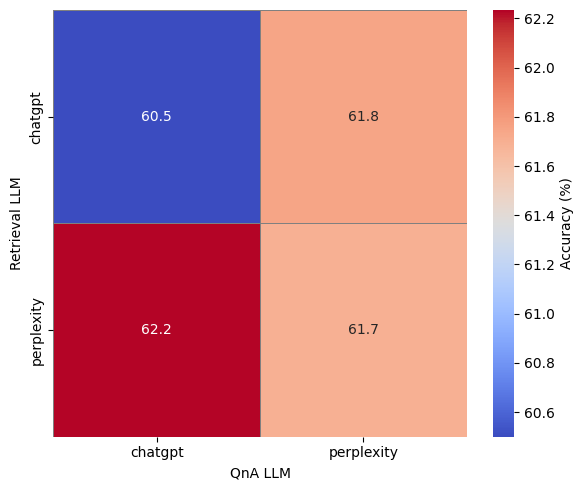

📊 Bar chart saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/Evaluation/RAG_accuracy_bar_chart.png


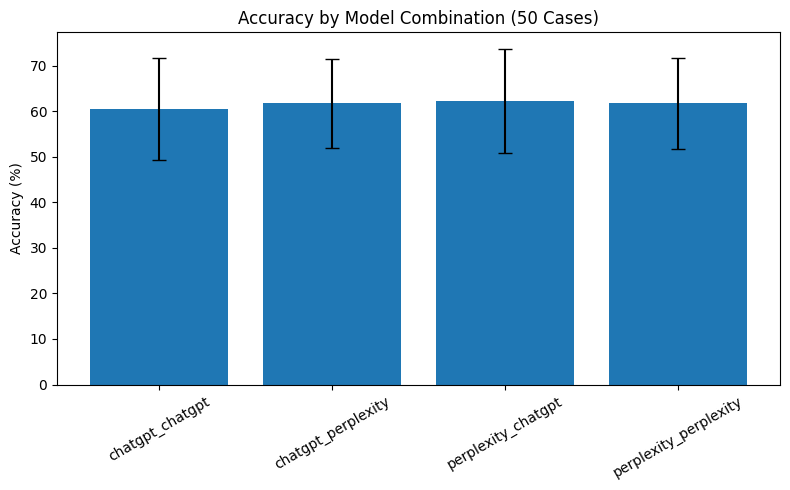

📊 Combined match comparison bar chart saved to: /home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG/Evaluation/RAG_accuracy_bar_match_comparison.png


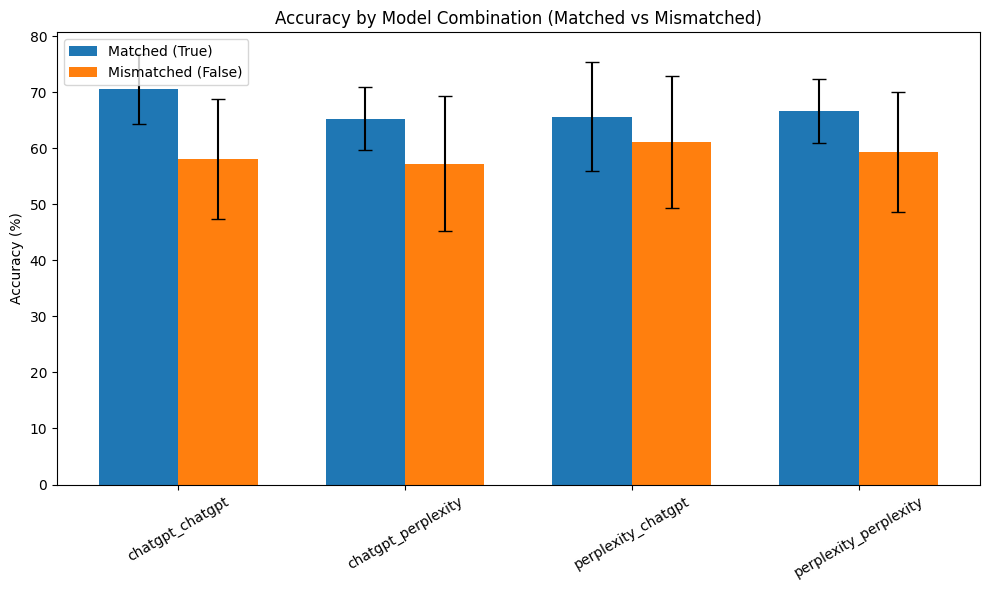

In [15]:
base_dir = "/home/cptaswadu/RESCUE-n8n/insurance/results/LLM_QnA/RAG"
summary_output_csv = os.path.join(base_dir, "Evaluation", "summary_accuracy.csv")

evaluate_all_folders_with_summary(
    base_dir=base_dir,
    gold_answers=ground_truth,
    summary_output_csv=summary_output_csv
)